In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 as cv2
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import gaussian, sobel, scharr
from skimage.feature import canny
from scipy import ndimage
import random
import tensorflow as tf
from tensorflow.keras import utils
import pandas as pd
import seaborn as sns
import pickle


%matplotlib inline


In [13]:
def create_data_files(directory, array, type=None, target_w=224, target_h=224, max_dim=5000):
    '''This function reads the images from the directory and creates datasets'''
    i = 0
    total_images = 0  # Track total images to process

    for category in categories:
        path = os.path.join(directory, category)  # Path to directory of images
        class_num = categories.index(category)  # Assign number to categories
        img_list = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
        total_images += len(img_list)

        for img in img_list:
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path)

                if img_array is None:  # Skip non-image files
                    print(f"Warning: File {img} in {category} is not a valid image.")
                    continue

                # Processing based on type
                if type == 'aspect':
                    img_array = cv2.cvtColor(img_array, cv2.IMREAD_GRAYSCALE)  # Convert to Grayscale
                    img_array = crop_and_resize(img_array, target_w, target_h, max_dim)
                    array.append([img_array, class_num])

                elif type == 'gray':
                    face_array = extract_face(img_array)  # Extract face
                    if face_array is not None:
                        gray_array = cv2.cvtColor(face_array, cv2.COLOR_BGR2GRAY)  # Convert to Gray
                        array.append([gray_array, class_num])

                elif type == 'rgb':
                    face_array = extract_face(img_array)  # Extract face
                    if face_array is not None:
                        rgb_array = cv2.cvtColor(face_array, cv2.COLOR_BGR2RGB)  # Convert to RGB
                        array.append([rgb_array, class_num])

                else:
                    print("Please specify image type ['aspect', 'gray', 'rgb']")
                    break

                i += 1

                # Print progress every 200 images
                if i % 200 == 0:
                    print(f"Images processed: {i} of {total_images}")

            except Exception as e:
                print(f"Error: \n category: {category}\n image: {img}\n reason: {e}")
                continue  # Skip the problematic image

    print(f"Finished processing images. Total processed: {i} of {total_images}")


In [4]:
def show_img(num, img_array, title, ncols=1):
    '''this function display images from an image array'''
    ncols= ncols
    nrows= int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize =(ncols*4,nrows*4))
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i in range(num):
        ax[i].imshow(img_array[i][0], cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)

In [5]:

# print summaries:
def print_summary(train_array, test_array):
    print(f'\nTraining Dataset:\n')
    print(f'Shape: {train_array.shape}')
    print(f'Classes: {np.unique(train_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(train_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(train_array[0][0][:])}')
    print('\n--------------------------------------\n')
    print(f'\nTesting Dataset:\n')
    print(f'Shape: {test_array.shape}')
    print(f'Classes: {np.unique(test_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(test_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(test_array[0][0][:])}')
    print('\n--------------------------------------\n')


In [6]:
# print summaries:
def print_summary(train_array, test_array):
    print(f'\nTraining Dataset:\n')
    print(f'Shape: {train_array.shape}')
    print(f'Classes: {np.unique(train_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(train_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(train_array[0][0][:])}')
    print('\n--------------------------------------\n')
    print(f'\nTesting Dataset:\n')
    print(f'Shape: {test_array.shape}')
    print(f'Classes: {np.unique(test_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(test_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(test_array[0][0][:])}')
    print('\n--------------------------------------\n')

In [7]:
def train_test_prep(training_data_array, testing_data_array):

    # shuffle the images to mix all the 5 classes randomly
    random.shuffle(training_data_array)
    random.shuffle(testing_data_array)

    # read and split X_train, X_test, y_train, y_test into an array
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for features, label in training_data_array:
        X_train.append(features)
        y_train.append(label)

    for features, label in testing_data_array:
        X_test.append(features)
        y_test.append(label)

    # change data types/format for X
    X_train = np.array(X_train, dtype=float)
    X_test = np.array(X_test, dtype=float)

    X_train = X_train/255
    X_test = X_test/255

    # change values of y to categorical
    y_train = utils.to_categorical(y_train, 5)
    y_test = utils.to_categorical(y_test, 5)

    return(X_train, X_test, y_train, y_test)

In [8]:
def pickle_out(X_train, X_test, y_train, y_test, version):
    '''To save the data out for modelling'''
    
    # Tentukan path tempat menyimpan file
    data_path = 'C:/Users/whisn/FaceShape Dataset/data/'

    # Periksa apakah folder data ada, jika tidak buat
    if not os.path.exists(data_path):
        os.makedirs(data_path)

    # Simpan X_train
    name_xtn = data_path + 'X_train_' + version + '.pickle'
    with open(name_xtn, "wb") as pickle_file:
        pickle.dump(X_train, pickle_file)

    # Simpan y_train
    name_ytn = data_path + 'y_train_' + version + '.pickle'
    with open(name_ytn, "wb") as pickle_file:
        pickle.dump(y_train, pickle_file)

    # Simpan X_test
    name_xts = data_path + 'X_test_' + version + '.pickle'
    with open(name_xts, "wb") as pickle_file:
        pickle.dump(X_test, pickle_file)

    # Simpan y_test
    name_yts = data_path + 'y_test_' + version + '.pickle'
    with open(name_yts, "wb") as pickle_file:
        pickle.dump(y_test, pickle_file)

    print(f"Data saved with version '{version}'")


In [9]:
# Assign the drives for image data, and specify the classes / labels
train_dir = 'C:/Users/whisn/FaceShape Dataset/training_set'
test_dir = 'C:/Users/whisn/FaceShape Dataset/testing_set'
categories = ['Heart','Oblong','Oval','Round','Square']
label_map = {0:'Heart', 1: 'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square'}

In [10]:
# create path to images in examples

ex_path = 'C:/Users/whisn/FaceShape Dataset/examples'
ex_files = os.listdir(ex_path)

examples = []

for i in ex_files:
    img = os.path.join(ex_path,i)
    examples.append(img)

examples = sorted(examples)
examples

['C:/Users/whisn/FaceShape Dataset/examples\\heart (7).jpg',
 'C:/Users/whisn/FaceShape Dataset/examples\\landscape.jpg',
 'C:/Users/whisn/FaceShape Dataset/examples\\oblong (7).jpg',
 'C:/Users/whisn/FaceShape Dataset/examples\\oval (1).jpg',
 'C:/Users/whisn/FaceShape Dataset/examples\\portrait.jpg',
 'C:/Users/whisn/FaceShape Dataset/examples\\round (1).JPG',
 'C:/Users/whisn/FaceShape Dataset/examples\\square (1).jpg']

In [12]:
def crop_and_resize(image, target_w=224, target_h=224, max_dim=5000):
    '''This function crops & resizes images to the target size by keeping aspect ratio, 
    and scales down large images to a manageable size.'''
    
    # Check if the image dimensions are too large
    if image.shape[0] > max_dim or image.shape[1] > max_dim:
        scaling_factor = max_dim / max(image.shape[0], image.shape[1])
        new_width = int(image.shape[1] * scaling_factor)
        new_height = int(image.shape[0] * scaling_factor)
        image = cv2.resize(image, (new_width, new_height))
        print(f"Image resized to {new_width}x{new_height} to fit within max_dim {max_dim}")

    # Proceed with cropping and resizing as before
    if image.ndim == 2:
        img_h, img_w = image.shape  # for Grayscale
    elif image.ndim == 3:
        img_h, img_w, channels = image.shape  # for RGB

    target_aspect_ratio = target_w / target_h
    input_aspect_ratio = img_w / img_h

    if input_aspect_ratio > target_aspect_ratio:
        resize_w = int(input_aspect_ratio * target_h)
        resize_h = target_h
        img = cv2.resize(image, (resize_w, resize_h))
        crop_left = int((resize_w - target_w) / 2)  # Crop left/right equally
        crop_right = crop_left + target_w
        new_img = img[:, crop_left:crop_right]
    elif input_aspect_ratio < target_aspect_ratio:
        resize_w = target_w
        resize_h = int(target_w / input_aspect_ratio)
        img = cv2.resize(image, (resize_w, resize_h))
        crop_top = int((resize_h - target_h) / 4)  # Crop top/bottom proportionally
        crop_bottom = crop_top + target_h
        new_img = img[crop_top:crop_bottom, :]
    else:
        new_img = cv2.resize(image, (target_w, target_h))

    return new_img


In [14]:
portrait = cv2.imread(
    'C:/Users/whisn/FaceShape Dataset/examples/portrait.jpg',
    cv2.IMREAD_GRAYSCALE)
landscape = cv2.imread(
    'C:/Users/whisn/FaceShape Dataset/examples/landscape.jpg',
    cv2.IMREAD_GRAYSCALE)

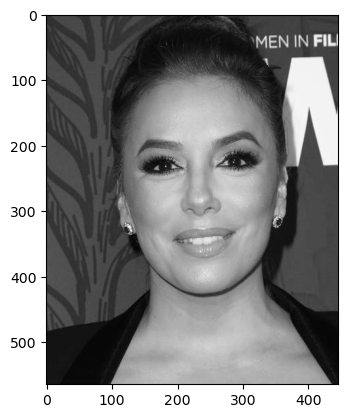

In [15]:
# original image
plt.imshow(portrait,cmap='gray');

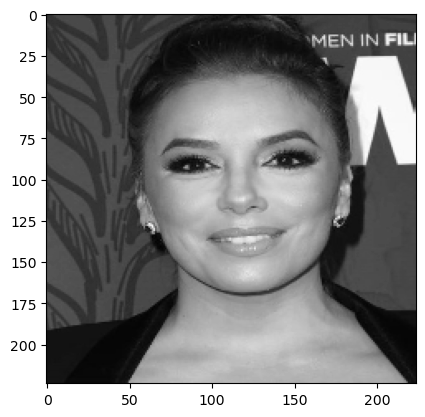

In [16]:
# auto resize by 224 - will be distorted
resized_ptrt = cv2.resize(portrait,(224,224))
plt.imshow(resized_ptrt, cmap='gray')

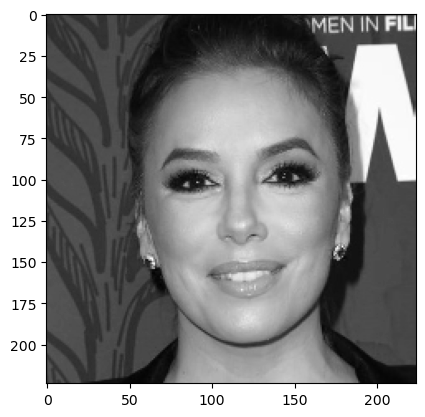

In [17]:
# test if the function works on portrait photos
new_ptrt = crop_and_resize(portrait)
plt.imshow(new_ptrt,cmap='gray');

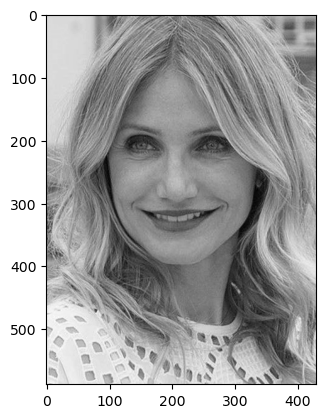

In [18]:
# original image
plt.imshow(landscape,cmap='gray');

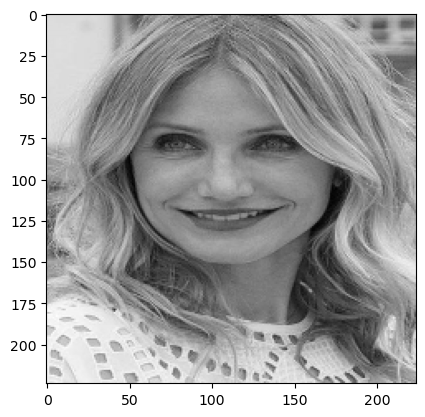

In [19]:
# auto resize by 224 - will be distorted
resized_lscp = cv2.resize(landscape,(224,224))
plt.imshow(resized_lscp, cmap='gray')

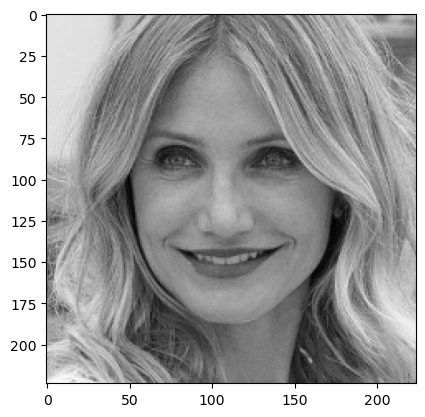

In [20]:
# test if the function works on landscape photos
new_lscp = crop_and_resize(landscape)
plt.imshow(new_lscp,cmap='gray');

In [21]:
!pip install mtcnn
import mtcnn
from mtcnn.mtcnn import MTCNN

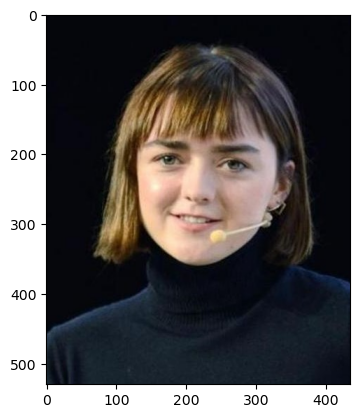

In [22]:
img = cv2.imread('C:/Users/whisn/FaceShape Dataset/examples/round (1).JPG')
img2 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img2);

In [23]:
# creates detector
detector = MTCNN()
# detect faces in an image
results = detector.detect_faces(img2)
results

[{'box': [134, 120, 184, 227],
  'confidence': 0.9995391368865967,
  'keypoints': {'nose': [216, 259],
   'mouth_right': [253, 294],
   'right_eye': [267, 214],
   'left_eye': [179, 207],
   'mouth_left': [176, 285]}}]

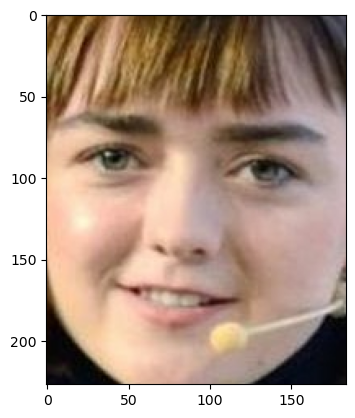

In [24]:
# extract the bounding box from the face

x1, y1, width, height = results[0]['box']
x2, y2 = x1+width, y1+height

face = img2[y1:y2, x1:x2]
plt.imshow(face);

x1 = 134
x2 = 318
y1 = 120
y2 = 347


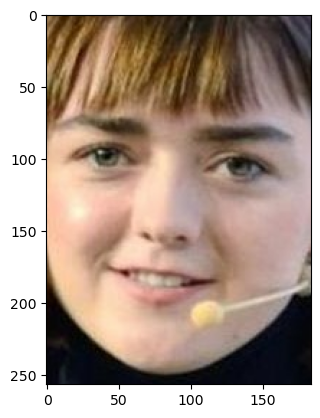

In [25]:
print(f'x1 = {x1}')
print(f'x2 = {x2}')
print(f'y1 = {y1}')
print(f'y2 = {y2}')

# first fix the heights by adding 10 pix each side
face_2 = img2[y1-10:y2+20, x1:x2];
plt.imshow(face_2);

h=257
w=184


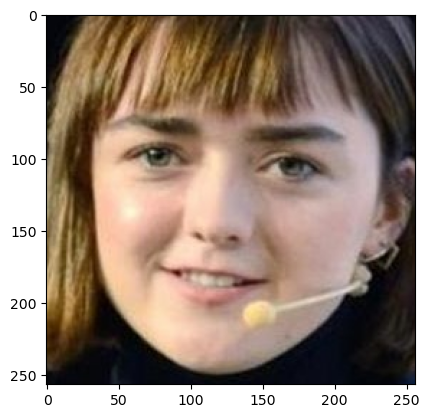

In [26]:
# then add the width to be square
h = (y2+20) - (y1-10)
w = x2-x1
print(f'h={h}')
print(f'w={w}')

adj_h = 10
adj_w = int((h-w)/2)

new_y1 = y1-adj_h
new_y2 = y2+(adj_h*2)

new_x1 = x1-adj_w
new_x2 = x2+adj_w

new_face = img2[new_y1:new_y2, new_x1:new_x2]
plt.imshow(new_face);

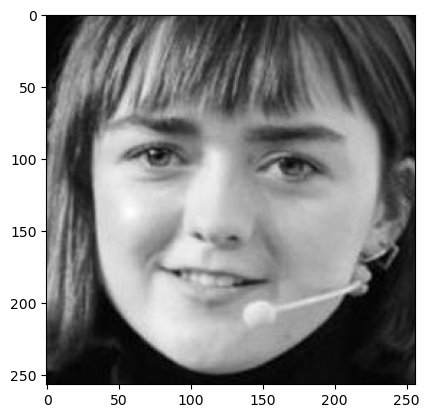

In [27]:
gray = cv2.cvtColor(new_face,cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap='gray');

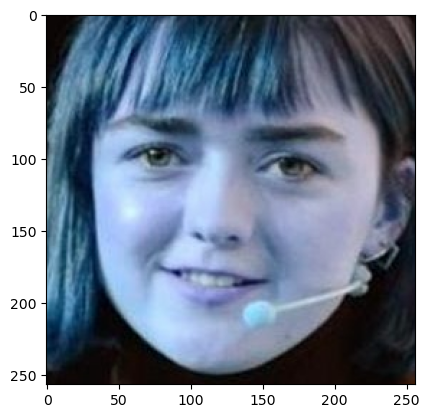

In [28]:
bgr = cv2.cvtColor(new_face,cv2.COLOR_RGB2BGR)
plt.imshow(bgr);

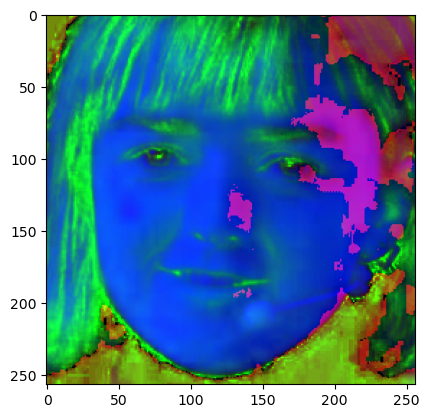

In [29]:
hsv = cv2.cvtColor(new_face,cv2.COLOR_RGB2HSV)
plt.imshow(hsv,cmap='gray');

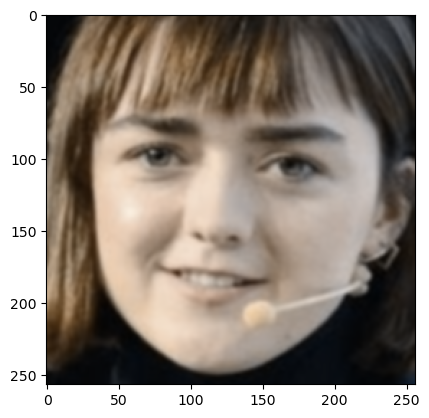

In [30]:
blur = gaussian(new_face)
plt.imshow(blur);

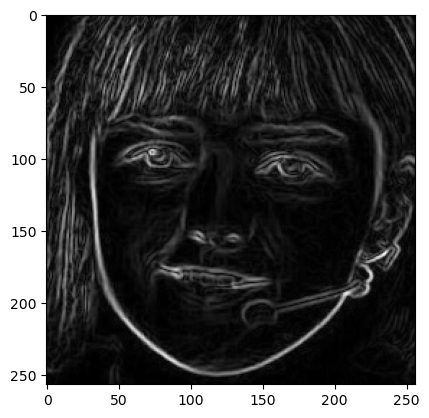

In [31]:
scharr_img = scharr(gray)

plt.imshow(scharr_img, cmap='gray');

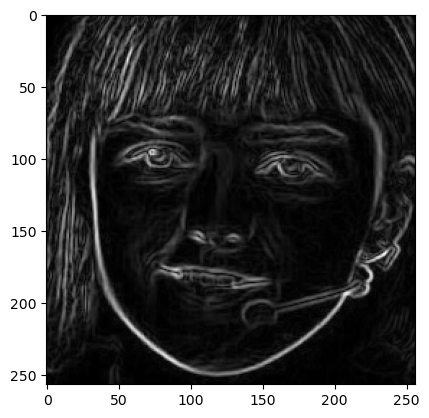

In [32]:
sobel_img = sobel(gray)
plt.imshow(sobel_img, cmap='gray');

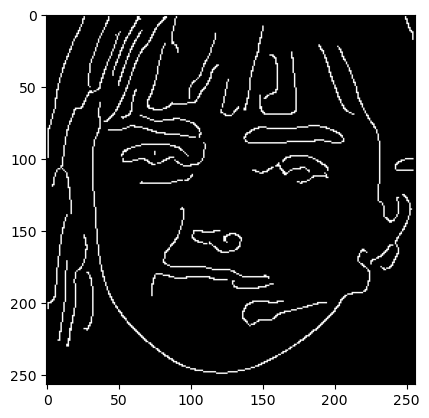

In [33]:
canny_img = canny(gray, sigma = 3)
plt.imshow(canny_img, cmap='gray');

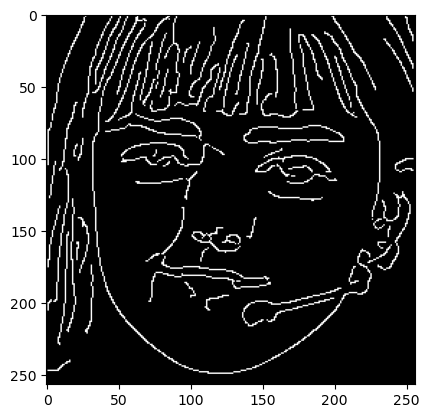

In [34]:
canny_img = canny(gray, sigma = 2)
plt.imshow(canny_img, cmap='gray');

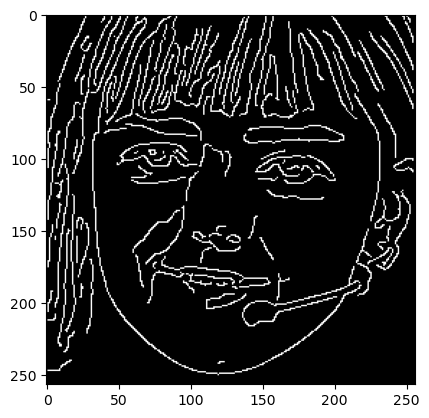

In [35]:
canny_img = canny(gray, sigma = 1.5)
plt.imshow(canny_img, cmap='gray');

In [36]:
def cvt_gabor(gray_img):
    ksize = 3
    sigma = 0.5
    theta = 1*np.pi/4
    lamda = 1*np.pi/4
    gamma = 0.8
    phi = 0

    gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)
    gb_img = cv2.filter2D(gray_img, cv2.CV_8UC3, gabor_kernel)

    return(gb_img)


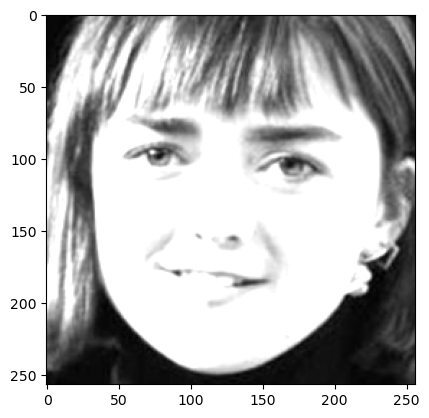

In [37]:
gabor_test = cvt_gabor(gray)
plt.imshow(gabor_test,cmap='gray');

In [38]:
# detector = MTCNN()  # creates detector

def extract_face(img, target_size=(224,224)):
    '''this functions extract face from different images by
    1) finds the facial bounding box
    2) slightly expands top & bottom boundaries to include the whole face
    3) crop into a square shape
    4) resize to target image size for modelling'''

    # 1. detect faces in an image

    results = detector.detect_faces(img)
    if results == []:
        new_face = crop_and_resize(img, target_w=224, target_h=224)
    else:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1+width, y1+height
        face = img[y1:y2, x1:x2]  # this is the face image from the bounding box before expanding bbox

        # 2. expand the top & bottom of bounding box by 10 pixels to ensure it captures the whole face
        adj_h = 10

        #assign value of new y1
        if y1-adj_h <10:
            new_y1=0
        else:
            new_y1 = y1-adj_h

        #assign value of new y2
        if y1+height+adj_h < img.shape[0]:
            new_y2 = y1+height+adj_h
        else:
            new_y2 = img.shape[0]
        new_height = new_y2 - new_y1

        # 3. crop the image to a square image by setting the width = new_height and expand the box to new width
        adj_w = int((new_height-width)/2)

        #assign value of new x1
        if x1-adj_w < 0:
            new_x1=0
        else:
            new_x1 = x1-adj_w

        #assign value of new x2
        if x2+adj_w > img.shape[1]:
            new_x2 = img.shape[1]
        else:
            new_x2 = x2+adj_w
        new_face = img[new_y1:new_y2, new_x1:new_x2]  # face-cropped square image based on original resolution

    # 4. resize image to the target pixel size
    sqr_img = cv2.resize(new_face, target_size)
    return sqr_img

In [39]:
examples_dir = "C:/Users/whisn/FaceShape Dataset/examples"
examples = [os.path.join(examples_dir, f) for f in os.listdir(examples_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

print(f"Found {len(examples)} images in examples directory.")

Found 6 images in examples directory.


In [40]:
print("Files in directory:")
print(os.listdir(examples_dir))

Files in directory:
['heart (7).jpg', 'landscape.jpg', 'oblong (7).jpg', 'oval (1).jpg', 'portrait.jpg', 'round (1).JPG', 'square (1).jpg']


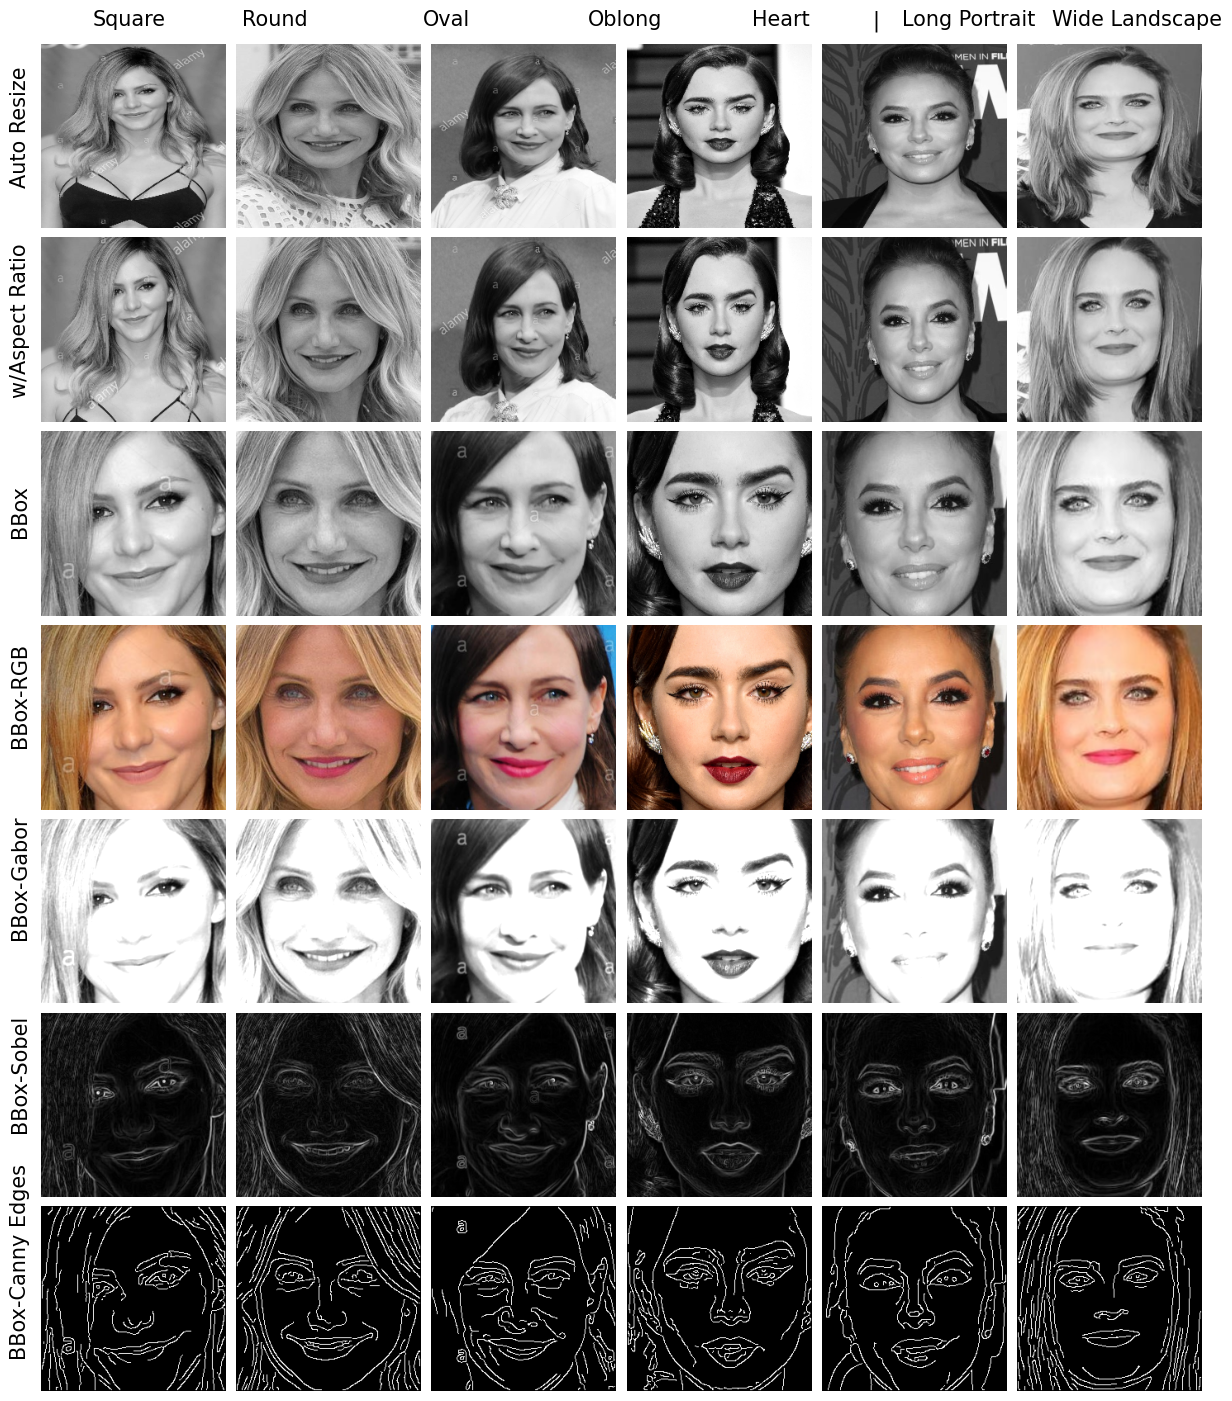

In [41]:
# test the function on the examples

n_images = len(examples)

fig, ax = plt.subplots(nrows=7, ncols=n_images, figsize=(n_images*2.5, (7*2.5)))
plt.gray()

ax= ax.ravel()

for i, file in enumerate(examples):

    img = cv2.imread(file)
    new_img = extract_face(img) # call function to extract face

    rsz_img = cv2.resize(img,(224,224))
    rsz_img = cv2.cvtColor(rsz_img,cv2.COLOR_BGR2GRAY)
    ax[i].imshow(rsz_img)
    ax[i].axis('off')

    aspct_img = crop_and_resize(img, target_w=224, target_h=224)
    aspct_img = cv2.cvtColor(aspct_img,cv2.COLOR_BGR2GRAY)
    ax[i+(n_images*1)].imshow(aspct_img)
    ax[i+(n_images*1)].axis('off')

    rgb_img = cv2.cvtColor(new_img,cv2.COLOR_BGR2RGB)
    ax[i+(n_images*3)].imshow(rgb_img)
    ax[i+(n_images*3)].axis('off')

    gray_img = cv2.cvtColor(new_img,cv2.COLOR_BGR2GRAY)
    ax[i+(n_images*2)].imshow(gray_img)
    ax[i+(n_images*2)].axis('off')

    gabor_img = cvt_gabor(gray_img)
    ax[i+(n_images*4)].imshow(gabor_img)
    ax[i+(n_images*4)].axis('off')

    sobel_img = sobel(gray_img)
    ax[i+(n_images*5)].imshow(sobel_img)
    ax[i+(n_images*5)].axis('off')

    canny_img = canny(gray_img, sigma=1.5)
    ax[i+(n_images*6)].imshow(canny_img)
    ax[i+(n_images*6)].axis('off')

plt.subplots_adjust(hspace=0.05, wspace=0.05)

plt.figtext(x=0.105, y=0.8, s="Auto Resize", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.68, s="w/Aspect Ratio", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.6, s="BBox", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.48, s="BBox-RGB", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.37, s="BBox-Gabor", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.26, s="BBox-Sobel", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.13, s="BBox-Canny Edges", fontsize=15, rotation=90)
plt.figtext(x=0.16, y=0.89, s="Square", fontsize=15)
plt.figtext(x=0.26, y=0.89, s="Round", fontsize=15)
plt.figtext(x=0.38, y=0.89, s="Oval", fontsize=15)
plt.figtext(x=0.49, y=0.89, s="Oblong", fontsize=15)
plt.figtext(x=0.6, y=0.89, s="Heart", fontsize=15)
plt.figtext(x=0.68, y=0.89, s="|", fontsize=15)
plt.figtext(x=0.7, y=0.89, s="Long Portrait", fontsize=15)
plt.figtext(x=0.8, y=0.89, s="Wide Landscape", fontsize=15);


In [52]:
# create new training & testing data with resizing

training_data_apr = []
testing_data_apr = []

create_data_files(train_dir, training_data_apr, 'aspect')
create_data_files(test_dir, testing_data_apr, 'aspect')


Images processed: 200 of 800
Images processed: 400 of 800
Images processed: 600 of 800
Images processed: 800 of 800
Images processed: 1000 of 1599
Images processed: 1200 of 1599
Images processed: 1400 of 1599
Images processed: 1600 of 2399
Images processed: 1800 of 2399
Images processed: 2000 of 2399
Images processed: 2200 of 2399
Images processed: 2400 of 3199
Images processed: 2600 of 3199
Images processed: 2800 of 3199
Images processed: 3000 of 3199
Image resized to 3329x5000 to fit within max_dim 5000
Images processed: 3200 of 3999
Images processed: 3400 of 3999
Images processed: 3600 of 3999
Images processed: 3800 of 3999
Finished processing images. Total processed: 3999 of 3999
Images processed: 200 of 200
Images processed: 400 of 400
Image resized to 3333x5000 to fit within max_dim 5000
Images processed: 600 of 600
Images processed: 800 of 800
Images processed: 1000 of 1000
Finished processing images. Total processed: 1000 of 1000


In [53]:
X_train, X_test, y_train, y_test = train_test_prep(training_data_apr, testing_data_apr)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (3999, 224, 224, 4)
X_test.shape (1000, 224, 224, 4)
y_train.shape (3999, 5)
y_test.shape (1000, 5)


In [54]:
# Pastikan hanya menggunakan 3 channel pertama (RGB) jika data memiliki lebih dari 3 channel
X_train = np.array(X_train)[:, :, :, :3]  # Slice untuk mengambil 3 channel pertama (RGB)
X_test = np.array(X_test)[:, :, :, :3]

print(f'X_train.shape {X_train.shape}')  # Harus (3999, 224, 224, 3)
print(f'X_test.shape {X_test.shape}')    # Harus (1000, 224, 224, 3)
print(f'y_train.shape {y_train.shape}')  # Harus tetap (3999, 5)
print(f'y_test.shape {y_test.shape}')    # Harus tetap (1000, 5)

X_train.shape (3999, 224, 224, 3)
X_test.shape (1000, 224, 224, 3)
y_train.shape (3999, 5)
y_test.shape (1000, 5)


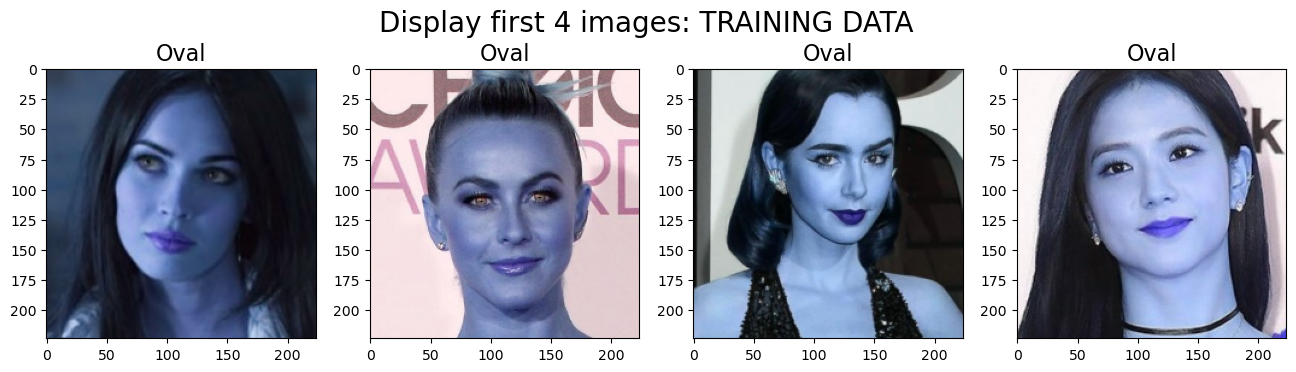

In [55]:
show_img(4, training_data_apr[:4], 'Display first 4 images: TRAINING DATA', ncols=4)

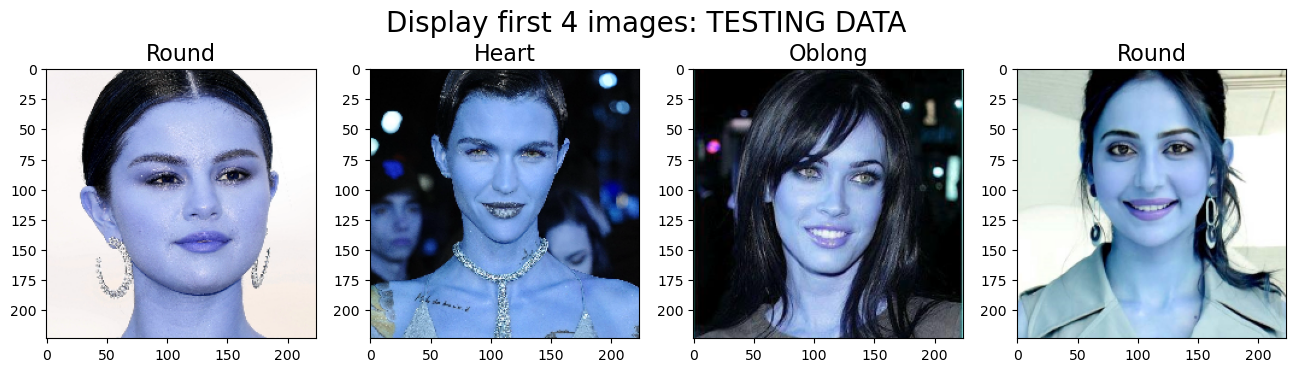

In [46]:
show_img(4, testing_data_apr[:4], 'Display first 4 images: TESTING DATA', ncols=4)

In [56]:
pickle_out(X_train, X_test, y_train, y_test, 'apr')

Data saved with version 'apr'


In [57]:
training_data_rgb = []
testing_data_rgb = []

create_data_files(train_dir, training_data_rgb, 'rgb')
create_data_files(test_dir, testing_data_rgb, 'rgb')

print(f'Training Images: {len(training_data_rgb)}')
print(f'Testing Images: {len(testing_data_rgb)}')

Images processed: 200 of 800
Images processed: 400 of 800
Images processed: 600 of 800
Images processed: 800 of 800
Images processed: 1000 of 1599
Error: 
 category: Oblong
 image: oblong (378).jpg
 reason: Unable to allocate 2.68 GiB for an array with shape (18978, 18978) and data type float64
Images processed: 1200 of 1599
Images processed: 1400 of 1599
Images processed: 1600 of 2399
Images processed: 1800 of 2399
Error: 
 category: Oval
 image: oval (37).jpg
 reason: Unable to allocate 6.24 GiB for an array with shape (28944, 28944) and data type float64
Images processed: 2000 of 2399
Images processed: 2200 of 2399
Images processed: 2400 of 3199
Images processed: 2600 of 3199
Images processed: 2800 of 3199
Images processed: 3000 of 3199
Images processed: 3200 of 3999
Images processed: 3400 of 3999
Images processed: 3600 of 3999
Images processed: 3800 of 3999
Finished processing images. Total processed: 3997 of 3999
Images processed: 200 of 200
Images processed: 400 of 400
Images pro

In [58]:
pickle_out(X_train, X_test, y_train, y_test, 'rgb')

Data saved with version 'rgb'


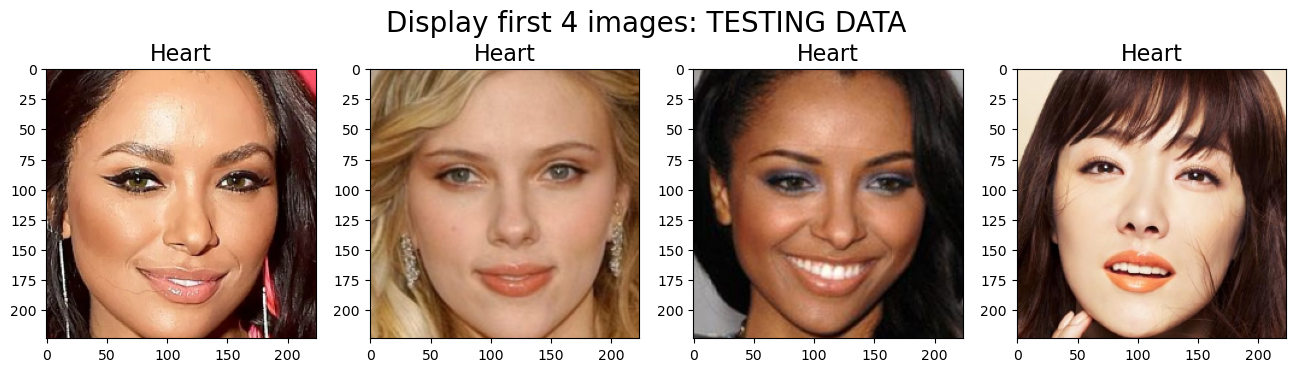

In [59]:
show_img(4, testing_data_rgb[:4], 'Display first 4 images: TESTING DATA', ncols=4)

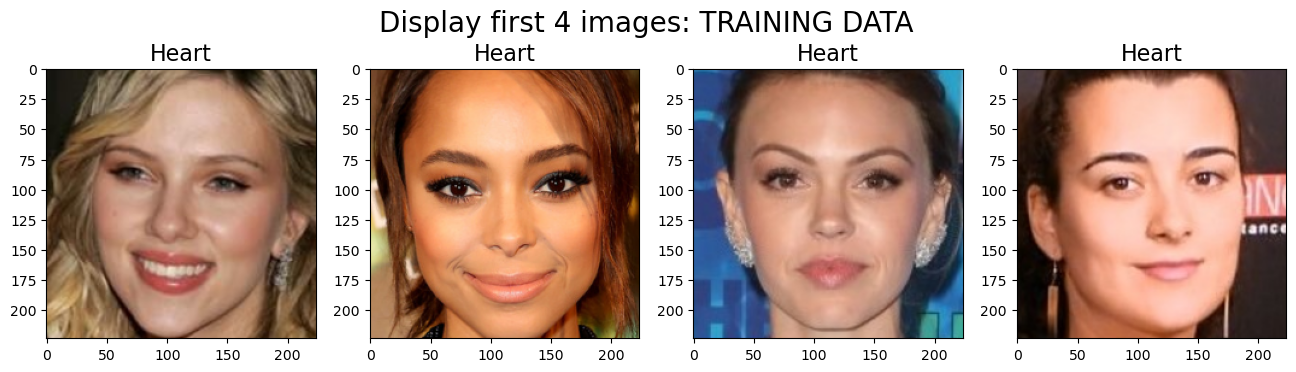

In [60]:
show_img(4, training_data_rgb[:4], 'Display first 4 images: TRAINING DATA', ncols=4)

In [47]:
import pickle
import os

# Tentukan path folder yang berisi file pickle
data_path = 'C:/Users/whisn/FaceShape Dataset/data/'

# Daftar nama file pickle yang ingin diperiksa
pickle_files = ['X_test_apr.pickle', 'X_train_apr.pickle', 'y_test_apr.pickle', 'y_train_apr.pickle']

# Memeriksa setiap file pickle
for pickle_file in pickle_files:
    file_path = os.path.join(data_path, pickle_file)
    
    # Membuka dan memuat isi file pickle
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    
    # Menampilkan tipe data dan bentuk data (jika data berupa array atau matrix)
    print(f"File: {pickle_file}")
    print(f"Type of data: {type(data)}")
    if hasattr(data, 'shape'):
        print(f"Shape of data: {data.shape}")
    
    # Menampilkan sebagian data untuk memastikan isinya
    print(f"Data preview (first 5 items): {data[:5]}\n")


File: X_test_apr.pickle
Type of data: <class 'numpy.ndarray'>
Shape of data: (1000, 224, 224, 1)
Data preview (first 5 items): [[[[0.9254902 ]
   [0.9254902 ]
   [0.9254902 ]
   ...
   [0.87058824]
   [0.81176471]
   [0.79215686]]

  [[0.9254902 ]
   [0.9254902 ]
   [0.9254902 ]
   ...
   [0.82745098]
   [0.83529412]
   [0.89411765]]

  [[0.9254902 ]
   [0.9254902 ]
   [0.9254902 ]
   ...
   [0.88627451]
   [0.83137255]
   [0.84313725]]

  ...

  [[0.9254902 ]
   [0.91764706]
   [0.90980392]
   ...
   [0.97254902]
   [0.91764706]
   [0.87058824]]

  [[0.9372549 ]
   [0.9254902 ]
   [0.91372549]
   ...
   [0.98823529]
   [0.98431373]
   [0.98039216]]

  [[0.9372549 ]
   [0.92941176]
   [0.91372549]
   ...
   [0.98039216]
   [0.98431373]
   [0.99607843]]]


 [[[0.97647059]
   [0.97647059]
   [0.97254902]
   ...
   [0.89411765]
   [0.89019608]
   [0.89019608]]

  [[0.97647059]
   [0.97647059]
   [0.97254902]
   ...
   [0.89411765]
   [0.89019608]
   [0.88627451]]

  [[0.97254902]
   [0.97